In [33]:
using DataFrames, ForwardDiff, Plots

In [34]:
# Stochastic gradient descent, logit.

df = readtable("../data/parsed_model_australia.txt", separator = ' ', header = false)

a, b = size(df)

const n_individuals = a
const n_alternatives = 4
const n_parameters = b

head(df)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
1,4,1,0,0,0,0,1,0,0,0,0,1,0,35,0,0,0,69,34,35,0,70,71,70,30
2,4,1,0,0,0,0,1,0,0,0,0,1,0,30,0,0,0,64,44,53,0,68,84,85,50
3,4,1,0,0,0,0,1,0,0,0,0,1,0,40,0,0,0,69,34,35,0,129,195,149,101
4,4,1,0,0,0,0,1,0,0,0,0,1,0,70,0,0,0,64,44,53,0,59,79,81,32
5,4,1,0,0,0,0,1,0,0,0,0,1,0,45,0,0,0,64,44,53,0,82,93,94,99
6,2,1,0,0,0,0,1,0,0,0,0,1,0,20,0,0,0,69,40,35,0,70,57,58,43


In [35]:
function individual(β::Vector, i::Int64)
    m, n = size(df)
    choice = df[i, 1][1]
    data = convert(Array, df[i, 2:n_parameters])
    alternatives = collect(1:n_alternatives)
    splice!(alternatives, choice)
    
    function utility(β::Vector, k::Int64)
        temp = Float64[]
        k += 1
        while k <= n_parameters
            push!(temp, df[i, k])
            k += n_alternatives
        end
        return dot(temp, β)
    end
    
    function logit(β::Vector)
        t = 0.0
        c = utility(β, choice)
        for alternative in alternatives
            t += exp(utility(β, alternative)-c)
        end
        return 1/(1+t)
    end
    
    return logit
end

individual (generic function with 1 method)

In [36]:
function f(β::Vector)
    model = 0.0
    i = 1
    while i <= n_individuals
        logit = individual(β, i)
        model += log(logit(β))
        i += 1
    end
    return -model/n_individuals
end

f (generic function with 1 method)

In [37]:
function g(x::Vector, i::Int64, j::Int64)
    t = zeros(length(x))
    for k = i:j
        logit = individual(x, k)
        t += (1/logit(x))*ForwardDiff.gradient(logit, x)
    end
    return -t/j
end

function g!(x::Vector, i::Int64, j::Int64, storage::Vector)
    s = g(x, i, j)
    storage[1:length(s)] = s[1:length(s)]
end

g! (generic function with 1 method)

In [38]:
function H(x::Vector)
    return ForwardDiff.hessian(f, x)
end

function H!(x::Vector, storage::Matrix)
    s = H(x)
    n, m = size(s)
    storage[1:n, 1:m] = s[1:length(s)]
end

H! (generic function with 1 method)

In [39]:
function shuffle!(df::DataFrame)
    for i = size(df, 1):-1:2
        j = rand(1:i)
        df[i, :], df[j, :] = df[j, :], df[i, :]
    end
end

shuffle! (generic function with 1 method)


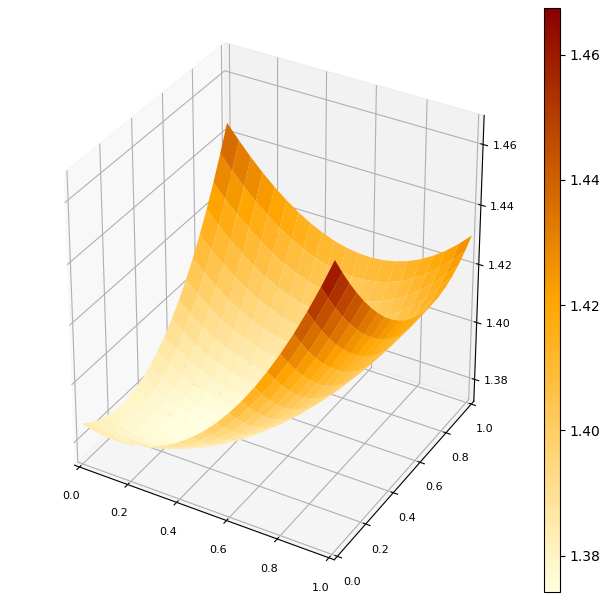

In [40]:
default(size = (600, 600), fc = :heat)
β1, β2 = 0:0.05:1.0, 0:0.05:1.0
z = Surface((β1, β2) -> f([β1, β2, 0, 0, 0, 0]), β1, β2)
surface(β1, β2, z, linealpha = 0.3)

In [41]:
function predict(β::Vector, i::Int64)
    logit = individual(β, i)
    return logit(β)
end

predict (generic function with 1 method)

In [42]:
function sgd(f::Function, g!::Function, ω0::Vector, η::Float64,
        batch::Int64 = 1, tol::Float64 = 1e-12, record::Bool = true)
    k = 1
    ω = ω0
    n = length(ω)
    dfx = ones(n)
    nmax = 25 # epochs
    change = 1.0
    if record
        fω = f(ω)
        iterates = [ fω ω' ]
    end
    # tol trop sévère, il va s'arrêter trop tôt.
    # while norm(dfx) > tol && k < nmax
    while k < nmax
        shuffle!(df)
        x = ω
        for i = 1:batch:n_individuals
            ω -= (η*g!(x, i, batch, dfx))
        end
        println("   ω = $ω")
        println("f(ω) = ", f(ω))
        if record
            fω = f(ω)
            iterates = [ iterates; fω ω' ]
        end
        change = abs(f(ω)-f(x))
        k += 1
    end
    if record
        return ω, k, iterates
    else
        return ω, k
    end
end

sgd (generic function with 4 methods)

In [43]:
# Solution avec Newton: [5.20744, 3.86904, 3.16319, 0.013287, -0.0961248, -0.0155015]

sol, epochs, iter = sgd(f, g!, [6.0, 4.0, 3.0, 0.0, 0.0, 0.0], 0.001)

sol, epochs

   ω = [5.99916, 4.00089, 2.99996, -0.050522, -0.0507072, 0.000714001]
f(ω) = 1.4901548222361856
   ω = [6.00011, 4.00022, 2.99973, -0.00763632, -0.00484526, -0.0382913]
f(ω) = 2.614504838051193
   ω = [5.99918, 4.00118, 2.99972, -0.0450073, -0.0559441, -0.000849402]
f(ω) = 1.3824700825329228
   ω = [5.99915, 4.00052, 2.99949, -0.0470684, -0.0883678, -0.03625]
f(ω) = 1.1310745947671204
   ω = [5.99896, 4.00044, 3.00008, -0.047816, -0.0858998, -0.0409522]
f(ω) = 1.147876126665822
   ω = [5.99994, 4.00035, 3.00005, -0.0185108, -0.00900739, -0.0274227]
f(ω) = 2.2913705937377844
   ω = [5.99899, 4.00031, 3.00003, -0.0849373, -0.0721387, 0.0976062]
f(ω) = 4.043434309818974
   ω = [5.99897, 4.00034, 3.00002, -0.085277, -0.0735205, 0.0978849]
f(ω) = 4.040818445111163
   ω = [5.99897, 3.99935, 3.00002, -0.0852778, -0.107519, 0.0250722]
f(ω) = 1.938985805051419
   ω = [5.99939, 3.99916, 2.99999, -0.0641074, -0.104511, 0.0620157]
f(ω) = 2.600042229236035
   ω = [6.00023, 3.99856, 2.99992, -0.049

([6.00146, 3.99651, 3.00158, -0.00986599, -0.110553, 0.0352951], 25)


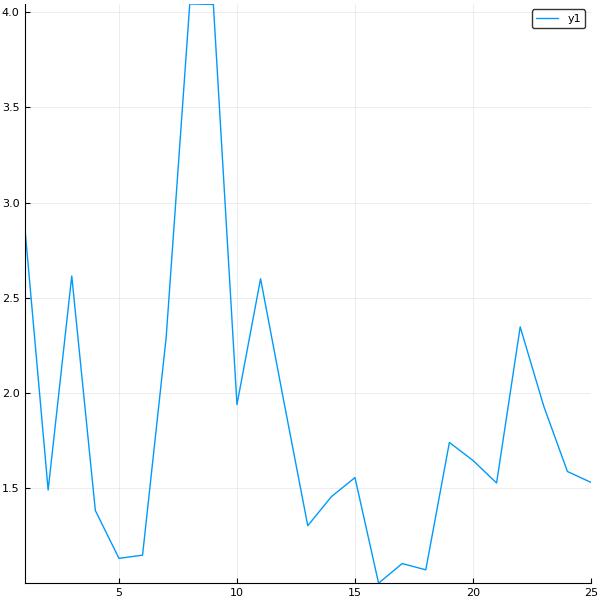

In [44]:
k = [x = i for i = 1:length(iter[:, 1])]

Plots.plot(k, iter[:, 1])